# Imports & Params

- Now ONLY supporting subject 1 !!!
- `pwd` directory should contain both `nsd_config.yaml` and `nsd_utils.py`

In nsd_config.yaml:
- Change data directory accordingly
- `voxel_size` can either be `1mm` or `1pt8mm`
- Choose [ROI files](https://cvnlab.slite.com/p/channel/CPyFRAyDYpxdkPK6YbB5R1/notes/X_7BBMgghj), extracted voxels will be the union of these ROIs. Visual cortex roi: `'prf-visualrois'`, `'prf-eccrois'`
- Create a folder for saving ROI masked voxel responses with `ROI_VOX` param, and `mkdir` for it under your `'nsddata_betas/ppdata/subj01/func1pt8mm/'`


In [1]:
import os
import ipdb
import h5py
import yaml
import json
import pickle
import numpy as np
from tqdm import tqdm
import nibabel as nib
import scipy.io as spio
import matplotlib.pyplot as plt

from nsd_utils import *

import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms

{'data': {'data_dir': '/home/sikun/NSD/data/', 'voxel_size': '1pt8mm', 'roi_files': ['prf-visualrois.nii.gz', 'floc-faces.nii.gz', 'floc-words.nii.gz', 'floc-places.nii.gz', 'floc-bodies.nii.gz'], 'roi_vox': 'roi_vox'}, 'device': 'cuda'}


- Stim (Image) h5 file: (73000, 425, 425, 3), 1 key: 'imgBrick' (`f.keys()`)
- Stim order mat: `_stim_order['subjectim'] (8, 10000)`, `_stim_order['masterordering'] (30000, )`
- Every beta file: (750, 83, 104, 81), 1 key: 'betas', in total 37 files for subj1

One thing to note, MIND THE INDEX:
- stim order file stim_order['subjectim'] ranges from 1-73000
- stim info file nsdId ranges from 0 to 72999

In [2]:
with open(STIM_INFO, 'rb') as f:
    stim_info = pickle.load(f, encoding='latin1')
stim_info

,cocoId,cocoSplit,cropBox,loss,nsdId,flagged,BOLD5000,shared1000,subject1,subject2,...,subject5_rep2,subject6_rep0,subject6_rep1,subject6_rep2,subject7_rep0,subject7_rep1,subject7_rep2,subject8_rep0,subject8_rep1,subject8_rep2
0,532481,val2017,"(0, 0, 0.1671875, 0.1671875)",0.100000,0,False,False,False,0,0,...,0,0,0,0,0,0,0,0,0,0
1,245764,val2017,"(0, 0, 0.125, 0.125)",0.000000,1,False,False,False,0,0,...,0,0,0,0,13985,14176,28603,0,0,0
2,385029,val2017,"(0, 0, 0.125, 0.125)",0.000000,2,False,False,False,0,0,...,0,0,0,0,0,0,0,0,0,0
3,311303,val2017,"(0, 0, 0.16640625, 0.16640625)",0.125000,3,False,False,False,0,0,...,0,0,0,0,0,0,0,0,0,0
4,393226,val2017,"(0, 0, 0.125, 0.125)",0.133333,4,False,False,False,0,0,...,0,13720,22861,23023,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72995,518071,train2017,"(0, 0, 0.125, 0.125)",0.000000,72995,False,False,False,0,0,...,0,0,0,0,0,0,0,6083,11650,26531
72996,255930,train2017,"(0, 0, 0.125, 0.125)",0.125000,72996,False,False,False,0,0,...,0,0,0,0,0,0,0,10402,10434,10625
72997,255934,train2017,"(0, 0, 0.1, 0.1)",0.000000,72997,False,False,False,0,0,...,0,0,0,0,0,0,0,0,0,0
72998,518080,train2017,"(0.125, 0.125, 0, 0)",0.000000,72998,False,False,False,0,0,...,0,0,0,0,5585,11846,14495,0,0,0


# Taking care of COCO (one-time only)

For accessing COCO notations
- `conda install -c conda-forge pycocotools`
- `mkdir nsddata_stimuli/stimuli/nsd/annotations`
- Download COCO annotation files: downloading function from [this repo](https://github.com/tknapen/nsd_access/blob/master/nsd_access/nsda.py)
- To get caption and category annotaitons faster at the sample loading stage, combine NSD annotations into single json files for easier access (no train-val split and reloading)

<font color='red'>**I already prepped the data so you can skip this section**</font>


In [ ]:
import zipfile
import urllib.request
from pandas.io.json import json_normalize
from pycocotools.coco import COCO

COCO_ANNOT = os.path.join(DATA_DIR, 'nsddata_stimuli/stimuli/nsd/annotations', '{}_{}.json')

In [ ]:
def download_coco_annotation_file(url='http://images.cocodataset.org/annotations/annotations_trainval2017.zip'):
    """download_coco_annotation_file downloads and extracts the relevant annotations files
    Parameters
    ----------
    url : str, optional
        url for zip file containing annotations, by default 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
    """
    print('downloading annotations from {}'.format(url))
    filehandle, _ = urllib.request.urlretrieve(url)
    zip_file_object = zipfile.ZipFile(filehandle, 'r')
    zip_file_object.extractall(path=os.path.split(os.path.split(COCO_ANNOT)[0])[0])

if not os.path.isfile(COCO_ANNOT.format('captions', 'train2017')):
    download_coco_annotation_file()

downloading annotations from http://images.cocodataset.org/annotations/annotations_trainval2017.zip


In [ ]:
if not os.path.isfile(STIM_CAP):
    nsd_captions = {}
    splits = ['train2017', 'val2017']

    for cur_split in splits:
        annot_file = COCO_ANNOT.format('captions', cur_split)
        coco = COCO(annot_file)
        print('getting annotations from ' + annot_file)

        for idx in tqdm(range(MAX_IDX)):
            nsdId = stim_order['subjectim'][0, stim_order['masterordering'][idx] - 1] - 1
            cocoId = int(stim_info['cocoId'][nsdId])
            
            if stim_info['cocoSplit'][nsdId] != cur_split:
                continue

            coco_annot_IDs = coco.getAnnIds([cocoId])
            coco_annot = coco.loadAnns(coco_annot_IDs)
            nsd_captions[cocoId] = []
            for i in range(len(coco_annot)):
                assert coco_annot[i]['image_id'] == cocoId
                cur_cap = coco_annot[i]['caption'].strip()
                # print(cur_cap)
                nsd_captions[cocoId].append(cur_cap)

    with open(STIM_CAP, 'w') as outfile:
        json.dump(nsd_captions, outfile)

loading annotations into memory...
Done (t=12.61s)
creating index...


 19%|█▊        | 5182/27750 [00:00<00:00, 26416.97it/s]

index created!
getting annotations from /home/sikun/NSD/data/nsddata_stimuli/stimuli/nsd/annotations/captions_train2017.json


  0%|          | 0/27750 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
getting annotations from /home/sikun/NSD/data/nsddata_stimuli/stimuli/nsd/annotations/captions_val2017.json


100%|██████████| 27750/27750 [00:00<00:00, 52671.68it/s]


In [ ]:
if not os.path.isfile(STIM_CAT):
    nsd_cat = {}
    splits = ['train2017', 'val2017']

    for cur_split in splits:
        annot_file = COCO_ANNOT.format('instances', cur_split)
        coco = COCO(annot_file)
        print('getting annotations from ' + annot_file)
        cat_ids = coco.getCatIds()
        categories = json_normalize(coco.loadCats(cat_ids))

        for idx in tqdm(range(MAX_IDX)):
            nsdId = stim_order['subjectim'][0, stim_order['masterordering'][idx] - 1] - 1
            cocoId = int(stim_info['cocoId'][nsdId])
            
            if stim_info['cocoSplit'][nsdId] != cur_split:
                continue

            coco_cats = []
            for cat_id in cat_ids:
                this_img_list = coco.getImgIds(catIds=[cat_id])
                if cocoId in this_img_list:
                    this_cat = np.asarray(categories[categories['id']==cat_id]['name'])[0]
                    coco_cats.append(this_cat)

            nsd_cat[cocoId] = coco_cats

    with open(STIM_CAT, 'w') as outfile:
        json.dump(d, outfile)

loading annotations into memory...
Done (t=31.81s)
creating index...


<ipython-input-148-41d19a933382>:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  categories = json_normalize(coco.loadCats(cat_ids))
  0%|          | 0/27750 [00:00<?, ?it/s]

index created!
getting annotations from /home/sikun/NSD/data/nsddata_stimuli/stimuli/nsd/annotations/instances_train2017.json


100%|██████████| 27750/27750 [1:09:36<00:00,  6.64it/s]


loading annotations into memory...
Done (t=1.60s)
creating index...
index created!


<ipython-input-148-41d19a933382>:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  categories = json_normalize(coco.loadCats(cat_ids))
  2%|▏         | 455/27750 [00:00<00:11, 2395.77it/s]

getting annotations from /home/sikun/NSD/data/nsddata_stimuli/stimuli/nsd/annotations/instances_val2017.json


100%|██████████| 27750/27750 [00:06<00:00, 4597.42it/s]


# Extract (and save) visual cortex voxels (<font color='red'>**one-time only**</font>)

- For the `extract_voxels` function, if choosing to flatten the masked voxels: to project a flattened fmri vector back to its 3d coordinate, use:
`tuple(zip(*np.where(mask==True)))`, which gives a length-(fmri vector) tuple, each item is a 3d coordinate

- For prf-visualrois roi, region 0-7 have the following number of voxels
```
0 ROI voxel count: 102447
1 ROI voxel count: 594
2 ROI voxel count: 756
3 ROI voxel count: 834
4 ROI voxel count: 599
5 ROI voxel count: 646
6 ROI voxel count: 541
7 ROI voxel count: 687
Total: 107104
```

In [20]:
extract_voxels(FMRI_DIR, ROI_FILES, ROI_VOX, flatten=True)

Extracting ROI based on prf-visualrois, available_regions: [0, 1, 2, 3, 4, 5, 6, 7, -1]
ROI voxel count: 107104
Extracting ROI based on floc-faces, available_regions: [0, 1, 2, 3, 5, -1]
ROI voxel count: 107112
Extracting ROI based on floc-words, available_regions: [0, 1, 2, 3, 4, 5, -1]
ROI voxel count: 107101
Extracting ROI based on floc-places, available_regions: [0, 1, 2, 3, -1]
ROI voxel count: 107099
Extracting ROI based on floc-bodies, available_regions: [0, 1, 2, 3, -1]
ROI voxel count: 107101

Total ROI voxel count: 107124



100%|██████████| 37/37 [16:15<00:00, 26.36s/it]


# Using dataset and getting samples

In [3]:
nsd_datast = NSDDataset(load_img=True, img_trans=None, load_fmri=True,
                        roi=ROI_VOX, load_caption=True, load_cat=True)

Single sample with verbose=True for sanity check. If not for checking, just use `nsd_dataset[idx]`

stim nsd id: 828, aka #829 in the tsv files.
stim shape: (425, 425, 3)
fmri loaded from /home/sikun/NSD/data/nsddata_betas/ppdata/subj01/func1pt8mm/roi_vox/betas_session01.hdf5
fmri shape: (107124,)
beta min, mean, max: -13759 21.959635562525673 20666
Captions:
A man on a surfboard, who is riding a wave.
A man riding a wave on top of a surfboard in the ocean.
a young man on a surfboard, surfing a wave
A guy in a wet suite riding a surfboard on a wave.
Surfer riding out end of wave with large breaking wave in background.
Categories: [['person', 'surfboard']]


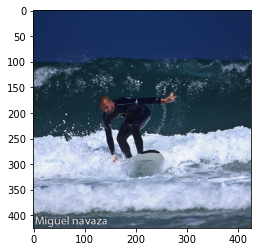

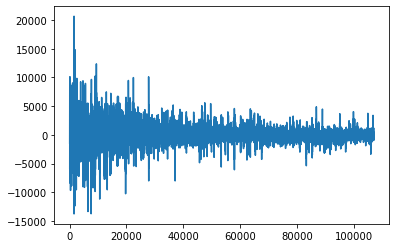

In [4]:
sample = nsd_datast.__getitem__(2, verbose=True)

plt.imshow(sample['img'])
plt.show()

plt.plot(sample['fmri'])
plt.show()

Accessing multiple samples

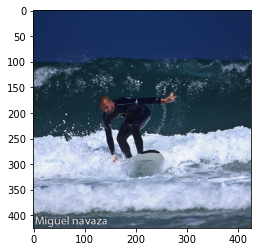

A man on a surfboard, who is riding a wave.
['person', 'surfboard']


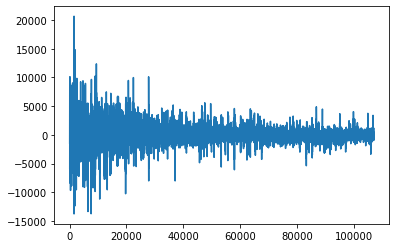

-13759 21.959635562525673 20666


In [5]:
samples = nsd_datast[1:4]

idx = -2
plt.imshow(samples['img'][idx])
plt.show()

print(samples['caption'][idx])
print(samples['cat'][idx])

fmri = samples['fmri'][idx]
plt.plot(fmri)
plt.show()
print(fmri.min(), fmri.mean(),fmri.max())

## **fmri volumn sanity check**
Compared dataset loaded fmri signal to nibabel loaded nii image

In [ ]:
idx = 3
nsd_datast = NSDDataset(load_img=True, img_trans=None, load_fmri=True,
                        roi=None, load_caption=True, load_cat=True)
sample = nsd_datast[idx]['fmri']
print(sample.shape)
nii_data = nib.load(os.path.join(FMRI_DIR, 'betas_session01.nii.gz')).get_fdata()
print(nii_data.shape)

assert (sample == nii_data[..., idx].T).all() == True

(83, 104, 81)
(81, 104, 83, 750)


# Noise Ceiling

official matlab [code](https://github.com/cvnlab/nsddatapaper/blob/a951ce8568e2691d69949925e836a4b389f42aa1/main/export_noiseceiling.m#L75)

In [3]:
from scipy.stats import zscore
zscored_dir = ROI_VOX+'_zscored'
n = 3 # repetition

In [5]:
'''One-time: z-score each voxel within each session--> (on visual cortex voxels)'''

for sess in tqdm(range(SESS_NUM)):
    in_file = os.path.join(ROI_VOX, f'betas_session{sess+1:02}.hdf5')
    out_file = os.path.join(zscored_dir, f'betas_session{sess+1:02}.hdf5')
    with h5py.File(in_file, 'r') as f:
        fmri = f['betas'][()]
    fmri = zscore(fmri, 0)
    with h5py.File(out_file, 'w') as f:
        dset = f.create_dataset('betas', data=fmri)

100%|██████████| 37/37 [04:19<00:00,  7.01s/it]


In [ ]:
stim_order = loadmat(STIM_ORDER_FILE)
nsd_datast = NSDDataset(load_img=False, img_trans=None, load_fmri=True,
                        roi=zscored_dir, load_caption=False, load_cat=False)

''' Go through all samples to build a dict with keys being their stimulus (image) IDs. '''
sig = {}
for idx in tqdm(range(MAX_IDX)):
    ''' nsdId as in design csv files''' 
    nsdId = stim_order['subjectim'][0, stim_order['masterordering'][idx] - 1] # - 1
    if nsdId not in sig:
        sig[nsdId] = []
    sig[nsdId].append(nsd_datast[idx]['fmri'])
sig = {k: np.stack(v) for k, v in sig.items()}
sig.keys()

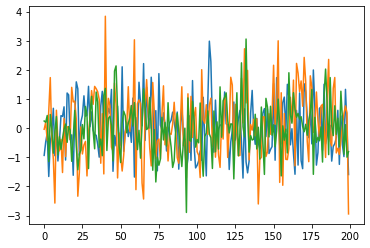

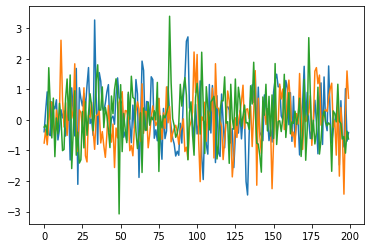

In [7]:
viz_len = 200
for i in range(n):
    plt.plot(sig[61883][i][:viz_len])
plt.show()

for i in range(n):
    plt.plot(sig[829][i][:viz_len])
plt.show()

## ncsnr & nc

100%|██████████| 9841/9841 [00:11<00:00, 831.36it/s]


8420
[1.00178488 1.00576523 0.99621672 ... 1.00195644 1.00099229 0.99518376]
median noise_std: 0.9932779458448019 mean noise_std: 0.9795120371004888, max noise_std: 1.0128270744502363


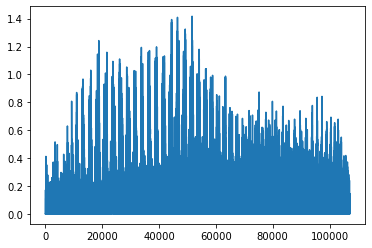

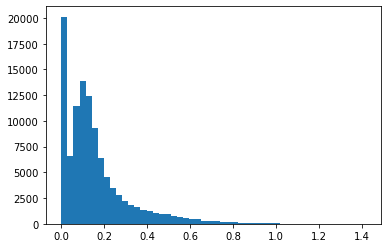

[0.         0.         0.08723367 ... 0.         0.         0.09850132]
median ncsnr: 0.11653708254979275, mean ncsnr: 0.1558557865953266 max ncsnr: 1.4169566126484265


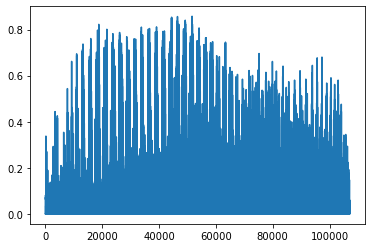

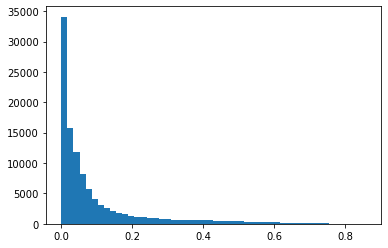

median nc: 0.03914769309882789, mean nc: 0.09307570305050168, max nc: 0.8576167518443626


In [8]:
_fmri_var = []
for k, v in tqdm(sig.items()):
    if len(v) != n:
        continue
    _fmri_var.append(np.var(v, 0, ddof=1))
print(len(_fmri_var))
noise_std = np.sqrt(np.stack(_fmri_var).mean(0)) # for every voxel, shape is (voxel_num,) 107104,
print(noise_std)
print(f'median noise_std: {np.median(noise_std)}',
      f'mean noise_std: {noise_std.mean()}, max noise_std: {max(noise_std)}')

signal_var = 1 - noise_std**2
'''based on https://github.com/cvnlab/nsddatapaper/blob/main/main/translatevmetric.m,
   only keep positive part'''
signal_std = np.sqrt(np.maximum(0, signal_var))
ncsnr = signal_std / noise_std
plt.plot(ncsnr)
plt.show()
plt.hist(ncsnr, bins=50)
plt.show()

print(ncsnr)
print(f'median ncsnr: {np.median(ncsnr)}, mean ncsnr: {ncsnr.mean()}',
      f'max ncsnr: {max(ncsnr)}')

'''Noice ceiling'''
nc = ncsnr**2 / (ncsnr**2 + 1.0/n)
plt.plot(nc)
plt.show()
plt.hist(nc, bins=50)
plt.show()

print(f'median nc: {np.median(nc)}, mean nc: {nc.mean()}, max nc: {max(nc)}')

In [9]:
''' nc for images, method from inter individual-DIR paper'''
for k, v in list(sig.items())[:5]:
    if len(v) != n:
        continue
    print(np.corrcoef(v))
    print(v.shape, (np.corrcoef(v).sum() - n) / (n**2 - n), '\n')

[[ 1.          0.05306531 -0.01975994]
 [ 0.05306531  1.          0.10227756]
 [-0.01975994  0.10227756  1.        ]]
(3, 107124) 0.04519431033717991 

[[ 1.         -0.02003828 -0.01423602]
 [-0.02003828  1.          0.08313986]
 [-0.01423602  0.08313986  1.        ]]
(3, 107124) 0.016288521705043985 

[[ 1.          0.03092566 -0.07604744]
 [ 0.03092566  1.         -0.02133367]
 [-0.07604744 -0.02133367  1.        ]]
(3, 107124) -0.022151815289285153 

[[ 1.         -0.02962775  0.02471387]
 [-0.02962775  1.          0.00466493]
 [ 0.02471387  0.00466493  1.        ]]
(3, 107124) -8.298651965713925e-05 

[[ 1.         -0.04624963  0.05329995]
 [-0.04624963  1.         -0.00750208]
 [ 0.05329995 -0.00750208  1.        ]]
(3, 107124) -0.00015058994948713433 



100%|██████████| 9841/9841 [00:00<00:00, 1417888.28it/s]


(8420, 3, 107124)


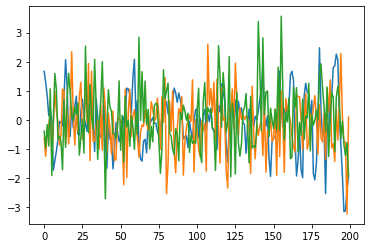

  0%|          | 46/107124 [00:00<03:55, 455.49it/s]


 [[ 1.          0.01151107 -0.00673858]
 [ 0.01151107  1.          0.00649323]
 [-0.00673858  0.00649323  1.        ]]


100%|██████████| 107124/107124 [02:10<00:00, 818.57it/s]


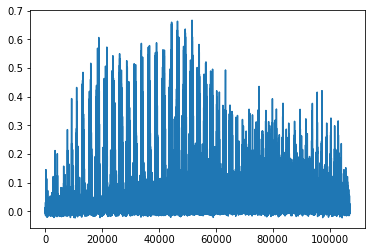

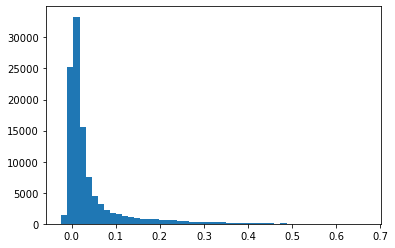

median nc: 0.014471060519166135, mean nc: 0.04029723954427431 max nc: 0.6666117497400711


In [10]:
'''nc for voxels, method from inter individual-DIR paper'''
vox_nc = []
num_vox = sig[829].shape[1]
_sig = []
for k, v in tqdm(sig.items()):
    if len(v) == n:
        _sig.append(v)
_sig = np.stack(_sig) # (num_img, repitition, num_vox)
print(_sig.shape)

''' visualize... n=4 repetitions for img_num_viz images'''
vox = 2500
img_num_viz = 200
for i in range(n):
    plt.plot(_sig[:img_num_viz, i, vox])
plt.show()
print('\n', np.corrcoef(_sig[...,vox], rowvar=False))

for i in tqdm(range(num_vox)):
    vox_cov = np.corrcoef(_sig[..., i], rowvar=False)
    vox_nc.append((vox_cov.sum() - n) / (n**2 - n))

vox_nc = np.asarray(vox_nc)
plt.plot(vox_nc)
plt.show()
plt.hist(vox_nc, bins=50)
plt.show()
print(f'median nc: {np.median(vox_nc)}, mean nc: {vox_nc.mean()}',
      f'max nc: {max(vox_nc)}')

## original version (not voxel-wise zscored)

In [ ]:
nc_sig_file = os.path.join(DATA_DIR, 'subj1_nc.pkl')
with open(nc_sig_file, 'rb') as f:
    sig = pickle.load(f)

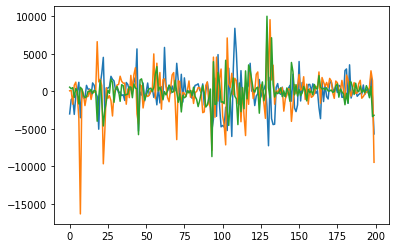

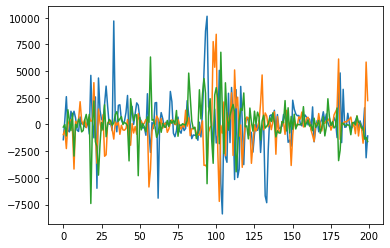

In [ ]:
viz_len = 200
for i in range(3):
    plt.plot(sig[61883][i][:viz_len])
plt.show()

for i in range(3):
    plt.plot(sig[829][i][:viz_len])
plt.show()

In [ ]:
''' correlation coefficient'''
for k, v in list(sig.items())[:5]:
    if len(v) != 3:
        continue
    print(np.corrcoef(v))

[[1.         0.13035274 0.08761433]
 [0.13035274 1.         0.17504699]
 [0.08761433 0.17504699 1.        ]]
[[1.         0.12556098 0.10711754]
 [0.12556098 1.         0.15652194]
 [0.10711754 0.15652194 1.        ]]
[[1.         0.22083298 0.18119897]
 [0.22083298 1.         0.2310477 ]
 [0.18119897 0.2310477  1.        ]]
[[1.         0.22474053 0.23826541]
 [0.22474053 1.         0.29258097]
 [0.23826541 0.29258097 1.        ]]
[[1.         0.12760652 0.08852729]
 [0.12760652 1.         0.14929798]
 [0.08852729 0.14929798 1.        ]]
